<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/model_by_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import pickle
import matplotlib.pyplot as plt


import tensorflow as tf
import keras 
print(tf.__version__)
print(keras.__version__)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

2.4.1
2.4.3


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load songs
songs = pd.read_csv('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/data/lana_lyrics_98.csv')
songs.shape

(98, 2)

In [6]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)

In [7]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 161722 characters
61 unique characters


In [8]:
corpus = list(set(text.lower().split('\n')))
corpus[:5]

['',
 "but at best, i can say i'm not sad",
 'need you, baby, more, more, more, more',
 "'cause we gonna take a ride",
 'you fucked me so good that i almost said "i love you"']

In [9]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(corpus)

# with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)


# load saved tokenizer
with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


total_words = len(tokenizer.word_index) + 1
print(total_words)

2575


In [10]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
input_sequences[20:30]

[[1, 470, 6],
 [1, 470, 6, 33],
 [1, 470, 6, 33, 128],
 [1, 470, 6, 33, 128, 17],
 [1, 470, 6, 33, 128, 17, 2],
 [1, 470, 6, 33, 128, 17, 2, 438],
 [1, 470, 6, 33, 128, 17, 2, 438, 89],
 [1, 470, 6, 33, 128, 17, 2, 438, 89, 2],
 [1, 470, 6, 33, 128, 17, 2, 438, 89, 2, 24],
 [1, 470, 6, 33, 128, 17, 2, 438, 89, 2, 24, 1]]

In [11]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding='pre'))

In [12]:
input_sequences[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  19,  53],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  19,  53, 216]], dtype=int32)

In [13]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors.shape, label.shape

((17490, 17), (17490,))

### Building The Model

In [21]:
K.clear_session()

def sparse_cat_loss(y_true,y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

vocab_size = total_words
embed_dim = 50
def create_model(vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))

    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    # A dropout layer for regularisation
    model.add(Dropout(0.1))
    # Add another LSTM Layer
    model.add(LSTM(100,return_sequences=False))
    # model.add(Dropout(0.1))
    model.add(Dense(vocab_size/2)) #activation='relu'
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(vocab_size, activation='softmax'))
    return model

model = create_model(vocab_size, embed_dim)
model.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 50)            128750    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           241200    
_________________________________________________________________
dropout (Dropout)            (None, 17, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1287)              129987    
_________________________________________________________________
dense_1 (Dense)              (None, 2575)              3316600   
Total params: 3,976,937
Trainable params: 3,976,937
Non-trainable params: 0
______________________________________________

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(predictors, label, epochs=100, verbose=1, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word/ldr_by_word')

Epoch 1/100
547/547 [==============================] - 9s 10ms/step - loss: 6.5976 - accuracy: 0.0300
Epoch 2/100
547/547 [==============================] - 5s 9ms/step - loss: 5.8109 - accuracy: 0.0565
Epoch 3/100
547/547 [==============================] - 5s 9ms/step - loss: 5.3597 - accuracy: 0.0878
Epoch 4/100
547/547 [==============================] - 5s 9ms/step - loss: 4.9414 - accuracy: 0.1245
Epoch 5/100
547/547 [==============================] - 5s 9ms/step - loss: 4.5532 - accuracy: 0.1509
Epoch 6/100
547/547 [==============================] - 5s 9ms/step - loss: 4.1535 - accuracy: 0.1850
Epoch 7/100
547/547 [==============================] - 5s 9ms/step - loss: 3.7686 - accuracy: 0.2293
Epoch 8/100
547/547 [==============================] - 5s 10ms/step - loss: 3.4299 - accuracy: 0.2728
Epoch 9/100
547/547 [==============================] - 5s 9ms/step - loss: 3.0703 - accuracy: 0.3323
Epoch 10/100
547/547 [==============================] - 5s 9ms/step - loss: 2.7340 - accu

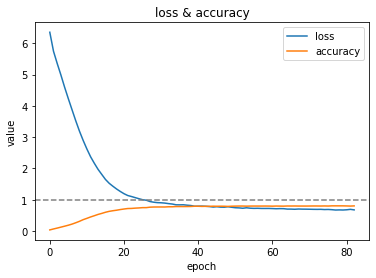

In [23]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='gray', linestyle='--')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### Recreate the model and load saved weights

In [24]:
# load saved tokenizer
with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer.pkl', 'rb') as f:
    tokenizer_reload = pickle.load(f)

In [25]:
# Create a new model instance
model_loaded = create_model(vocab_size, embed_dim)
model_loaded.load_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word/ldr_by_word')
model_loaded.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')

In [26]:
def make_lyrics(model, seed_text, next_words, tokenizer=tokenizer_reload):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [28]:
predicted_lyrics = make_lyrics(model_loaded, 'you\'re so art deco out on the floor shining like gun metal', 100)
print(predicted_lyrics)

you're so art deco out on the floor shining like gun metal was my dad this town baby town you playin' it and no tomorrow never came no no no no what what are make the boys just ever live and pray with life is makin' you pay shinin' his baby park now you side now they have crazy it's enough just to do every way or crazy at of my walls 'round the bitch mean it for my not we do it for fun we did it for free to talk about over of your are love me that ruined can change down that i heard that i'm higher and higher


In [29]:
predicted_lyrics = make_lyrics(model_loaded, 'country club', 100)
print(predicted_lyrics)

country club i'm off and the hide side through the side of a paradise happily crowd let you pay darling i'm none left and me go girl but i'm not scared there's nothing to lose now that i've found you when i hear bored i was only nineteen nineteen in any sad then you say about me i'm big songs are ours you my out now you and me like me but cinnamon at my dark trailer too heaven of what's it look at me at mmm us length don't wanna talk about some fuckin' hallelujah that i've had that's comin' life


Test Loaded model

In [30]:
predicted_lyrics = make_lyrics(model_loaded, 'I can see my sweet boy swinging', 100)
print(predicted_lyrics)

I can see my sweet boy swinging with you you're mine see you for my lie and with your gold piece of heaven died at the hold the mariners bench away i can change i love you i love you i and you honey save me wild wild wild at heart or and my heart by my side and paradise out of my darts in you or wanna i'll you if you don't wanna come to you i come to me better to me wild happy what is fine now i'm now quiet we do what next do it's enough just to make you feel crazy crazy


In [33]:
predicted_lyrics = make_lyrics(model_loaded, 'he\'s crazy', 100)
print(predicted_lyrics)

he's crazy y cubano como yo la la la la la losers beautiful losers yeah yeah yeah yeah oh yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah


In [34]:
predicted_lyrics = make_lyrics(model_loaded, 'jesus is my bestest friend', 100)
print(predicted_lyrics)

jesus is my bestest friend to the crowd next me seen me now i'm here with that writing makin' me back there can see into the blue into the blue blue blue blue blue blue blue blue blue blue blue blue blue bestest good in no die louder am far what you say with the metal move da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da da


In [ ]:
# word_counts_df = pd.DataFrame.from_dict(dict(tokenizer.word_counts), orient='index')
# word_counts_df.reset_index(inplace=True)
# word_counts_df.columns = ['word', 'count']

In [ ]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS as w_stop
len(w_stop)

190

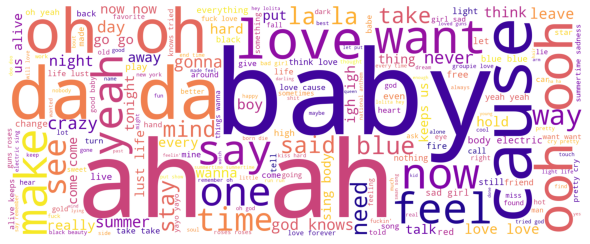

In [ ]:
stopwords = set(w_stop)
extra = ['got', 'know']
for word in extra:
    stopwords.add(word)

wordcloud = WordCloud(width = 2000, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10, 
                colormap='plasma').generate(text)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()